Doing what Shawn did

Setup

In [1]:
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


from library.datasets import Signal_Images_Dataset, Signal_Images_Single_Dataset
from library.nn_training import select_device, train_and_eval, Custom_Model
from library.plotting import plot_loss_curves, setup_high_quality_mpl_params, plot_prediction_linearity, make_plot_note

device = select_device()


Device:  cuda


Model definition

In [2]:
class Res_Block(nn.Module):
    def __init__(self, in_out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_channels=in_out_channels, out_channels=in_out_channels, kernel_size=3, stride=1, padding="same"),
            # nn.BatchNorm3d(num_features=in_out_channels),
            nn.ReLU(),
            nn.Conv3d(in_channels=in_out_channels, out_channels=in_out_channels, kernel_size=3, stride=1, padding="same"),
            # nn.BatchNorm3d(num_features=in_out_channels),
        )
        self.last_activation = nn.ReLU()
    def forward(self, x):
        x = self.block(x) + x
        x = self.last_activation(x)
        return x


class Conv_Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block_a = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding="same"),
            # nn.BatchNorm3d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv3d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding="same"),
            # nn.BatchNorm3d(num_features=out_channels),
        )
        self.block_b = nn.Sequential(
            nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding="same"),
            # nn.BatchNorm3d(num_features=out_channels),
        )
        self.last_activation = nn.ReLU()
    def forward(self, x):
        out_block_a = self.block_a(x)
        out_block_b = self.block_b(x)
        x = out_block_a + out_block_b
        x = self.last_activation(x)
        return x


class CNN_Res(Custom_Model):
    def __init__(self, nickname, model_dir,):
        super().__init__(nickname, model_dir)

        self.conv = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding="same", bias=False),
            # nn.BatchNorm3d(num_features=16),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=1, padding=1),
            *[Res_Block(in_out_channels=16) for _ in range(3)],
            Conv_Block(in_channels=16, out_channels=16),
            *[Res_Block(in_out_channels=16) for _ in range(3)],
            Conv_Block(in_channels=16, out_channels=16),
            *[Res_Block(in_out_channels=16) for _ in range(3)],
            # Conv_Block(in_channels=128, out_channels=128),
            # *[Res_Block(in_out_channels=128) for _ in range(1)],
        )

        self.dense = nn.Sequential(
            nn.Linear(in_features=16, out_features=32),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(in_features=32, out_features=1),
        )
        
        self.double()

    def forward(self, x):
        x = self.conv(x)
        x = torch.mean(x, dim=(2,3,4))
        x = self.dense(x)
        x = torch.squeeze(x)
        return x

Data loading

In [3]:
regenerate = True

level = "gen"
save_dir = "../../state/new_physics/data/processed"

common_generate_kwargs = {
    "raw_signal_dir": "../../state/new_physics/data/raw/signal",
    "std_scale": True,
    "q_squared_veto": True,
    "balanced_classes": True,
    "num_events_per_set": 70_000,
    "num_sets_per_label": 50,
    "n_bins": 10,
}

datasets = {
    "train": Signal_Images_Dataset(level=level, split="train", save_dir=save_dir),
    "eval": Signal_Images_Dataset(level=level, split="eval", save_dir=save_dir),
}

if regenerate:
    datasets["train"].generate(
        raw_trials=range(1,21), 
        **common_generate_kwargs
    )
    datasets["eval"].generate(
        raw_trials=range(21,41), 
        **common_generate_kwargs
    )

datasets["train"].load(device)
datasets["eval"].load(device)

opened raw file: [1/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_10_re.pkl
opened raw file: [2/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_11_re.pkl
opened raw file: [3/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_12_re.pkl
opened raw file: [4/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_13_re.pkl
opened raw file: [5/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_14_re.pkl
opened raw file: [6/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_15_re.pkl
opened raw file: [7/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_16_re.pkl
opened raw file: [8/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_17_re.pkl
opened raw file: [9/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_18_re.pkl
opened raw file: [10/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_19_re.pkl
opened raw file: [11/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_1_re.pkl
opened raw file: [12/876] ..\..\state\new_physics\data\raw\signa

Image Visualization

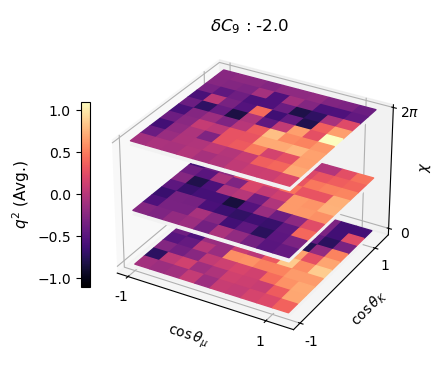

In [4]:
def plot_volume_slices(arr, n_slices=3, cmap=plt.cm.magma, note=""):
    """
    Plot slices of volumetric data.
    Slices are along the z-axis (axis 2).
    Array arr should be a three-dimensional array.
    Slices might not be evenly spaced along z-axis.
    """

    fig = plt.figure()
    ax_3d = fig.add_subplot(projection="3d")

    var_dim = {
        0: "chi",
        1: "costheta_mu",
        2: "costheta_K",
    }

    dim_ind_cart = { # dont change for now
        "x": 1,     
        "y": 2,
        "z": 0,  
    }

    norm=Normalize(vmin=-1.1, vmax=1.1)
    arr = arr.squeeze()
    arr = arr.cpu()
    arr = np.transpose(
        arr, 
        (dim_ind_cart["x"], dim_ind_cart["y"], dim_ind_cart["z"])
    )
    colors = cmap(norm(arr))
    
    cart_dim_shape = {
        dim_name: arr.shape[dim_ind_cart[dim_name]] for dim_name in dim_ind_cart.keys()
    }

    def xy_plane(z_pos):
        x, y = np.indices(
            (cart_dim_shape["x"] + 1, cart_dim_shape["y"] + 1)
        )
        z = np.full(
            (cart_dim_shape["x"] + 1, cart_dim_shape["y"] + 1), z_pos
        )
        return x, y, z
    
    def plot_slice(z_index):
        x, y, z = xy_plane(z_index) 
        ax_3d.plot_surface(
            x, y, z, 
            rstride=1, cstride=1, 
            facecolors=colors[:,:,z_index], 
            shade=False,
        )

    def plot_outline(z_index, offset=0.3):
        x, y, z = xy_plane(z_index - offset)
        
        ax_3d.plot_surface(
            x, y, z, 
            rstride=1, cstride=1, 
            shade=False,
            color="#f2f2f2",
            edgecolor="#f2f2f2", 
        )

    z_indices = np.linspace(0, cart_dim_shape["z"]-1, n_slices, dtype=int) # forces integer indices
    for i in z_indices:
        plot_outline(i)
        plot_slice(i)

    cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax_3d, location="left", shrink=0.5, pad=-0.05)
    cbar.set_label(r"${q^2}$ (Avg.)", size=11)

    ax_labels = {
        "chi": r"$\chi$", 
        "costheta_mu": r"$\cos\theta_\mu$",
        "costheta_K": r"$\cos\theta_K$",
    }

    ax_3d.set_xlabel(ax_labels[var_dim[dim_ind_cart["x"]]], labelpad=0)
    ax_3d.set_ylabel(ax_labels[var_dim[dim_ind_cart["y"]]], labelpad=0)
    # ax_3d.zaxis.set_rotate_label(False)
    ax_3d.set_zlabel(ax_labels[var_dim[dim_ind_cart["z"]]], labelpad=-3,)#rotation="horizontal") 

    ticks = {
        "costheta_mu": ["-1", "1"],
        "costheta_K": ["-1", "1"],
        "chi": ['0', r"$2\pi$"],
    }      

    ax_3d.set_xticks([0, arr.shape[dim_ind_cart["x"]]-1], ticks[var_dim[dim_ind_cart["x"]]])
    ax_3d.set_yticks([0, arr.shape[dim_ind_cart["y"]]-1], ticks[var_dim[dim_ind_cart["y"]]])
    ax_3d.set_zticks([0, arr.shape[dim_ind_cart["z"]]-1], ticks[var_dim[dim_ind_cart["z"]]])

    ax_3d.tick_params(pad=0.3)

    ax_3d.set_box_aspect(None, zoom=0.85)

    ax_3d.set_title(f"{note}", loc="center", y=1)


plot_volume_slices(
     datasets["train"].features[0], 
     n_slices=3, 
     note=r"$\delta C_9$ : "+f"{datasets["train"].labels[0]}"
)
# plt.savefig(f"{i}", bbox_inches="tight")
plt.show()
plt.close()

In [5]:
retrain = False

nickname = f"cnn_res_{common_generate_kwargs["num_events_per_set"]}"

model = CNN_Res(nickname, "../../state/new_physics/models")

if retrain:
    learning_rate = 4e-4
    epochs = 80
    train_batch_size = 32
    eval_batch_size = 32
    loss_fn = nn.L1Loss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    train_and_eval(
        model, 
        datasets["train"], datasets["eval"], 
        loss_fn, optimizer, 
        epochs, 
        train_batch_size, eval_batch_size, 
        device, 
        move_data=False,
        scheduler=ReduceLROnPlateau(optimizer, factor=0.9, patience=1),
        checkpoint_epochs=5,
    )
    _, ax = plt.subplots()
    plot_epoch_start = 0
    plot_loss_curves(
        model.loss_table["epoch"][plot_epoch_start:], 
        model.loss_table["train_loss"][plot_epoch_start:], 
        model.loss_table["eval_loss"][plot_epoch_start:], 
        ax
    )
    ax.set_yscale("log")
    plt.show()
else:
    pass
    # model.load_final()
    # model.load_checkpoint(epoch_number=10)
    # model.to(device)

Evaluate model (eval dataset)

final:
mse: 0.020801248992977372
mae: 0.11502789598713462


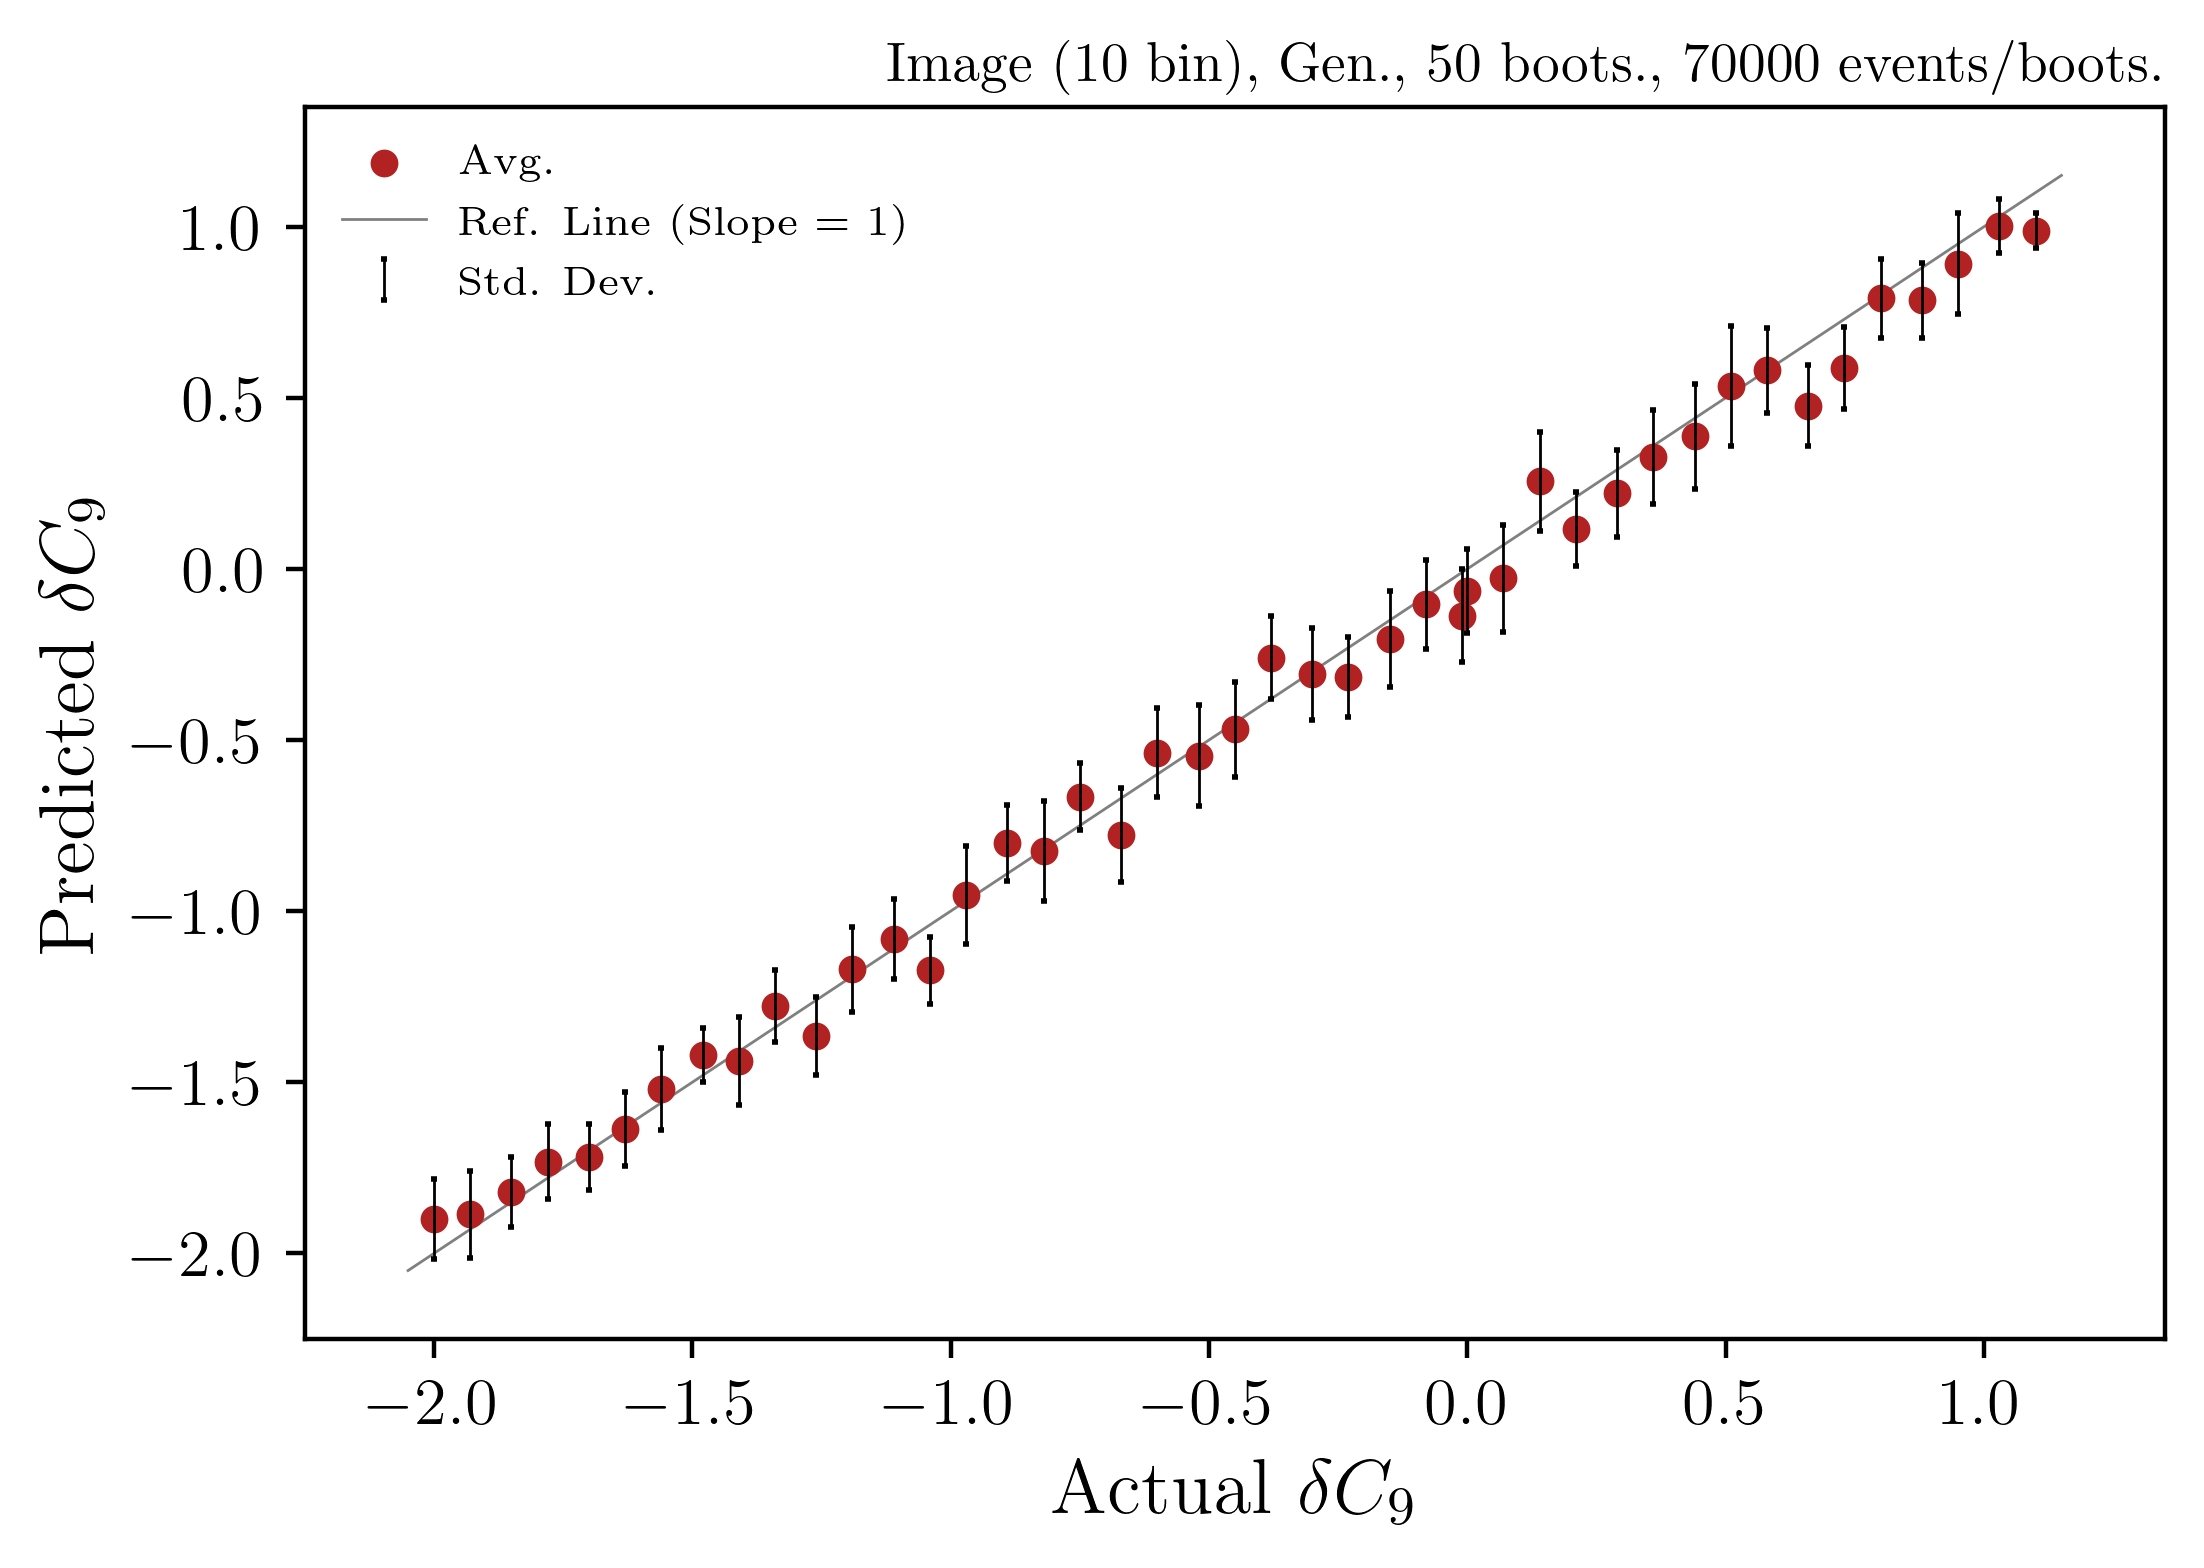

In [6]:
model = CNN_Res(nickname, "../../state/new_physics/models")

# for ep in range(0, 80, 5):
#     model.load_checkpoint(epoch_number=ep)
#     model.to(device)

#     model.eval()
#     with torch.no_grad():
        
#         yhat = model(datasets["eval"].features)
#         avgs = yhat.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
#         stds = yhat.reshape(-1, common_generate_kwargs["num_sets_per_label"]).std(1).detach().cpu().numpy()

#         y = datasets["eval"].labels
#         unique_y = y.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
#         unique_y

#         fig, ax = plt.subplots()
#         plot_prediction_linearity(ax, unique_y, avgs, stds)
#         plt.show()
#         plt.close()

setup_high_quality_mpl_params()


print("final:")

model.load_final()
model.to(device)

model.eval()
with torch.no_grad():
        
    yhat = model(datasets["eval"].features)
    avgs = yhat.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
    stds = yhat.reshape(-1, common_generate_kwargs["num_sets_per_label"]).std(1).detach().cpu().numpy()

    y = datasets["eval"].labels
    unique_y = y.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
    unique_y

    def calc_mse():
        dif = yhat.detach().cpu().numpy() - y.detach().cpu().numpy()
        dif_sq = dif**2
        out = dif_sq.mean()
        return out

    def calc_mae():
        dif = yhat.detach().cpu().numpy() - y.detach().cpu().numpy()
        abs_dif = np.abs(dif)
        out = abs_dif.mean()
        return out
    
    print("mse:", calc_mse())
    print("mae:", calc_mae())

    fig, ax = plt.subplots()

plot_prediction_linearity(
    ax,
    unique_y,
    avgs,
    stds,
    ref_line_buffer=0.05,
    xlim=(-2.25, 1.35),
    ylim=(-2.25, 1.35),
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)
make_plot_note(ax, f"Image (10 bin), Gen., {common_generate_kwargs["num_sets_per_label"]} boots., {common_generate_kwargs["num_events_per_set"]} events/boots.", fontsize="medium")

plt.show()
plt.close()

Evaluate model (train dataset)

In [ ]:
model = CNN_Res(nickname, "../../state/new_physics/models")

for ep in range(0, 50, 5):
    model.load_checkpoint(epoch_number=ep)
    model.to(device)

    model.eval()
    with torch.no_grad():
        
        yhat = model(datasets["train"].features)
        avgs = yhat.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
        stds = yhat.reshape(-1, common_generate_kwargs["num_sets_per_label"]).std(1).detach().cpu().numpy()

        y = datasets["train"].labels
        unique_y = y.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
        unique_y

        fig, ax = plt.subplots()
        plot_prediction_linearity(ax, unique_y, avgs, stds)
        plt.show()
        plt.close()


print("final:")

setup_high_quality_mpl_params()

model = CNN_Res(nickname, "../../state/new_physics/models")

model.load_final()
model.to(device)

model.eval()
with torch.no_grad():
        
    yhat = model(datasets["train"].features)
    avgs = yhat.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
    stds = yhat.reshape(-1, common_generate_kwargs["num_sets_per_label"]).std(1).detach().cpu().numpy()

    y = datasets["train"].labels
    unique_y = y.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
    unique_y

    fig, ax = plt.subplots()

plot_prediction_linearity(
    ax,
    unique_y,
    avgs,
    stds,
    ref_line_buffer=0.05,
    xlim=(-2.25, 1.35),
    ylim=(-2.25, 1.35),
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)
make_plot_note(ax, f"Image (10 bin), Gen., {common_generate_kwargs["num_sets_per_label"]} boots., {common_generate_kwargs["num_events_per_set"]} events/boots.", fontsize="medium")

plt.show()
plt.close()

In [7]:

regenerate = True

level = "gen"
save_dir = "../../state/new_physics/data/processed"
num_events_per_set = 6_000
num_sets_per_label = 2_000

single_eval_dset = Signal_Images_Single_Dataset(level=level, split="eval", save_dir=save_dir)

if regenerate:
    single_eval_dset.generate(
        raw_trials=range(21,41), 
        raw_signal_dir="../../state/new_physics/data/raw/signal",
        num_events_per_set=num_events_per_set,
        num_sets_per_label=num_sets_per_label,
        n_bins=10,
        value=-0.82,
    )

single_eval_dset.load()

opened raw file: [1/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_21_re.pkl
opened raw file: [2/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_22_re.pkl
opened raw file: [3/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_23_re.pkl
opened raw file: [4/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_24_re.pkl
opened raw file: [5/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_25_re.pkl
opened raw file: [6/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_26_re.pkl
opened raw file: [7/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_27_re.pkl
opened raw file: [8/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_28_re.pkl
opened raw file: [9/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_29_re.pkl
opened raw file: [10/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_30_re.pkl
opened raw file: [11/879] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_31_re.pkl
opened raw file: [12/879] ..\..\state\new_physics\data\raw\sign

In [4]:

single_eval_dset.features

tensor([[[[[-4.6703e-01, -4.8868e-01, -6.1540e-01,  ..., -2.3993e-01,
            -6.4720e-01, -1.2147e-01],
           [-1.7896e-01, -2.7819e-01, -1.1904e-01,  ..., -3.4920e-01,
            -3.1891e-01, -2.6765e-02],
           [-4.4881e-02, -2.1006e-03,  2.4542e-03,  ..., -1.4170e-01,
            -2.7728e-01, -3.0720e-01],
           ...,
           [ 1.7633e-01,  2.0996e-01,  2.2935e-01,  ..., -5.7950e-01,
            -4.6064e-01, -3.5004e-01],
           [ 2.5774e-01,  1.8202e-01,  2.4176e-01,  ..., -5.2535e-01,
            -6.0610e-01, -2.9838e-01],
           [ 1.6516e-01,  4.0532e-01,  5.6623e-01,  ...,  4.3104e-01,
            -3.7843e-02, -8.4098e-02]],

          [[-3.1383e-01, -4.5331e-01, -2.7727e-01,  ..., -6.9520e-01,
            -4.9992e-01, -3.3547e-02],
           [ 1.4335e-01, -2.0619e-01, -1.4965e-01,  ..., -2.9400e-01,
            -2.2689e-01,  4.7207e-02],
           [-1.7182e-01, -1.9020e-01,  1.3665e-01,  ..., -1.2627e-01,
             3.9863e-02,  2.3044e-02],
 

In [5]:
single_eval_dset.labels

tensor([-0.8200, -0.8200, -0.8200,  ..., -0.8200, -0.8200, -0.8200],
       dtype=torch.float64)

In [1]:
nickname =f"cnn_res_{num_events_per_set}"
model = CNN_Res(nickname, "../../state/new_physics/models")
model.load_final()
model.to(device)
model.eval()
nickname

NameError: name 'num_events_per_set' is not defined

In [9]:
with torch.no_grad():
    yhats = []
    for s in single_eval_dset.features:
        yhat = model(s.unsqueeze(0).to(device))
        yhats.append(yhat.detach().cpu())
    yhats = np.array(yhats)

    mean = yhats.mean()
    std = yhats.std()


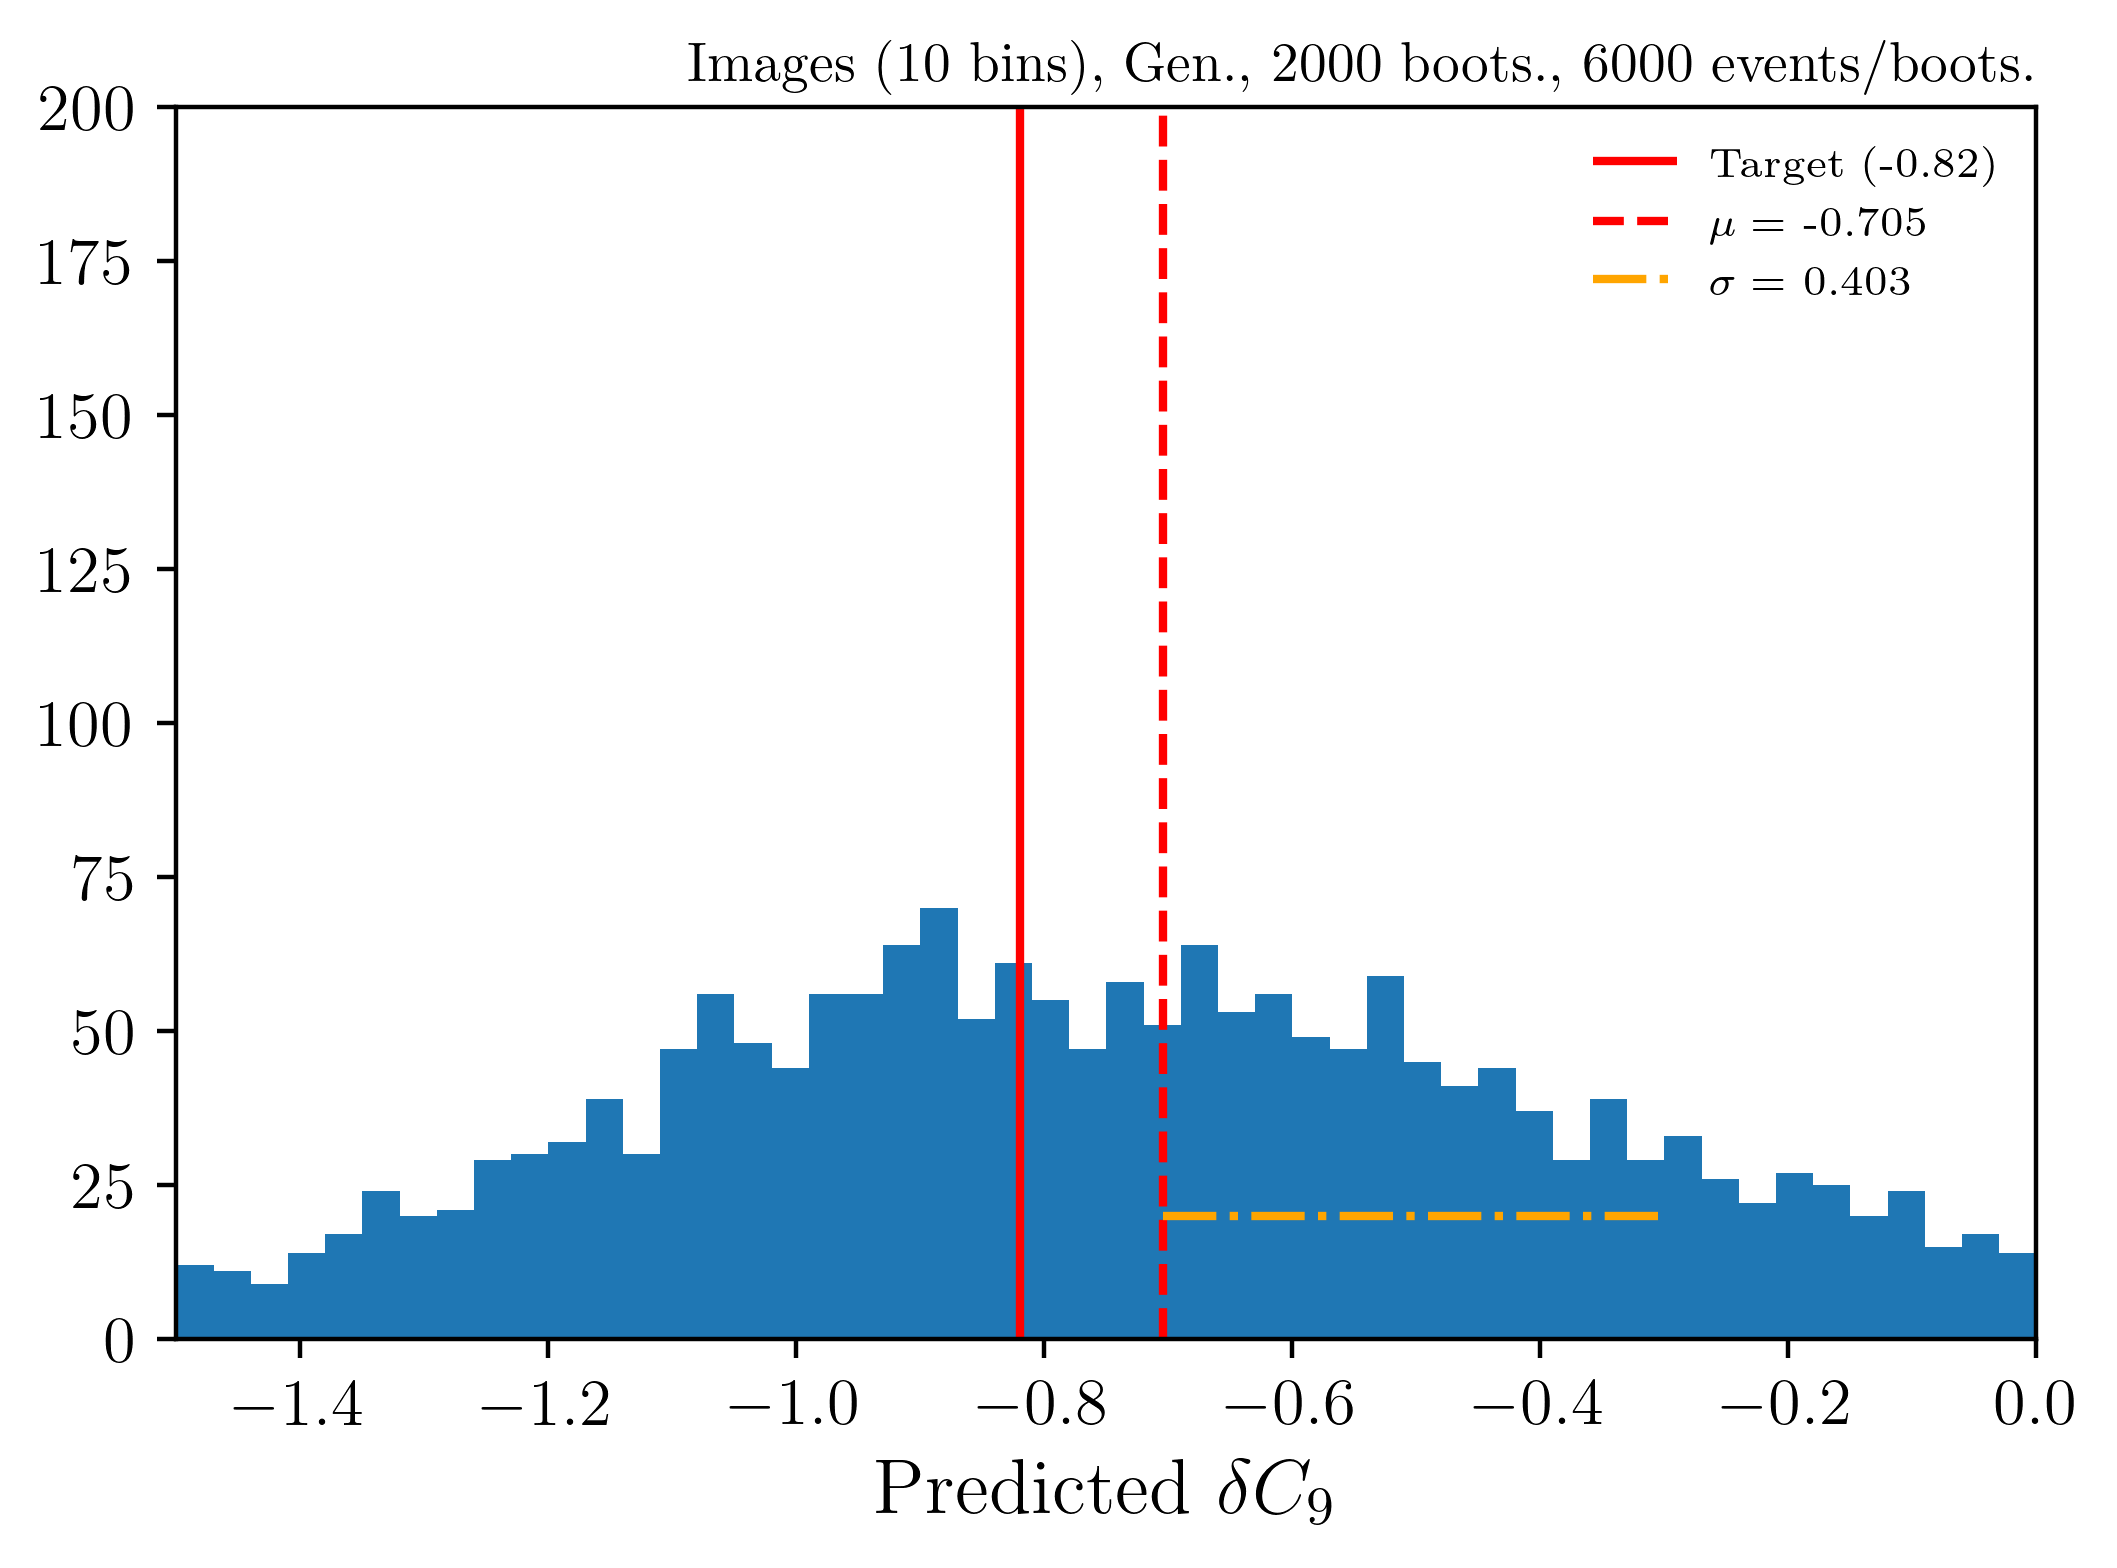

In [14]:
setup_high_quality_mpl_params()
fig, ax = plt.subplots()

xbounds = (-1.5, 0)
ybounds = (0, 200)

ax.hist(yhats, bins=50, range=xbounds)
ax.vlines(-0.82, 0, ybounds[1], color="red", label="Target (-0.82)")
ax.vlines(mean, 0, ybounds[1], color="red", linestyles="--", label=r"$\mu = $ "+f"{mean.round(3)}")
ax.hlines(20, mean, mean+std, color="orange", linestyles="dashdot", label=r"$\sigma = $ "+f"{std.round(3)}")
ax.set_xlabel(r"Predicted $\delta C_9$")
make_plot_note(ax, f"Images (10 bins), Gen., {num_sets_per_label} boots., {num_events_per_set} events/boots.", fontsize="medium")
ax.set_xbound(*xbounds)
ax.set_ybound(*ybounds)
ax.legend()


plt.show()